### A DM/eotest comparison of bias and offset corrections

#### Imports

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy as np
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage

# eotest imports
import lsst.eotest.image_utils as imutil

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

### Construct the `IsrTask` with the above configuration

In [5]:
isr = IsrTask(config=isr_config)

### Access images from the Butler

In [64]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)

## Query BIAS images from FLAT acquisition
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'BIAS', 'testType': 'FLAT'})

## Specifiy a visit/sensor/amplifier
visit = visits[0]
sensor = 2
amp = 'C16'

dId = {'visit': visit, 'detector': sensor}
raw1 = butler.get('raw', **dId)
bias1 = butler.get('bias', **dId)

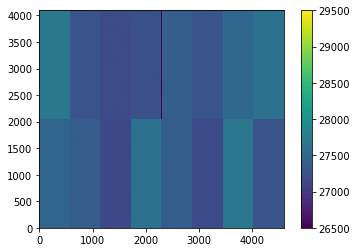

In [61]:
## What do these images look like?

plt.imshow(raw1.getImage().getArray(), origin='lower', vmin=26500, vmax=29500)
plt.colorbar()
plt.show()

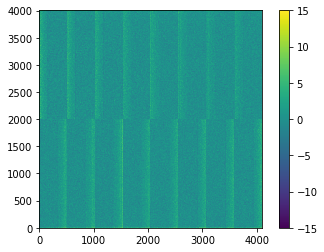

In [62]:
plt.imshow(bias1.getImage().getArray(), origin='lower', vmin=-15, vmax=15)
plt.colorbar()
plt.show()

### Stack ISR bias/offset correction

In [9]:
## Run ISR bias and offset correction
result1 = isr.run(raw1.clone(), bias=bias1.clone())

In [10]:
## Get subimage for a specific amplifier
detector = result1.exposure.getDetector()
amplifier = detector[amp]

sub_im1 = result1.exposure.getMaskedImage()[amplifier.getBBox()]

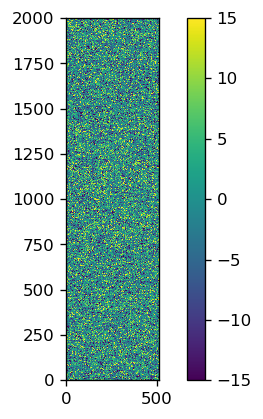

In [29]:
plt.imshow(sub_im1.getImage().getArray(), origin='lower', vmin=-15, vmax=15)
plt.colorbar()
plt.show()

### eotest bias/offset correction

In [75]:
def get_superbias(visits, sensor, amp):
    
    n = len(visits)

    images = []
    for i in range(n):
        dId = {'visit': visits[i], 'detector': sensor}
        raw = butler.get('raw', **dId)
        detector = raw.getDetector()
        data_bbox =  detector[amp].getRawBBox()
        im = raw[data_bbox].getMaskedImage().getImage().clone()
        images.append(im)
    
    oscan = detector[amp].getRawHorizontalOverscanBBox()
    #imaging = detector[amp].getRawDataBBox()
    
    unbiased = [imutil.unbias_and_trim(im0, oscan, bias_method='spline') for im0 in images]
    superbias = afwMath.statisticsStack(unbiased, afwMath.MEDIAN)
    
    return(superbias)

In [76]:
superbias = get_superbias(visits[:20], sensor, amp)

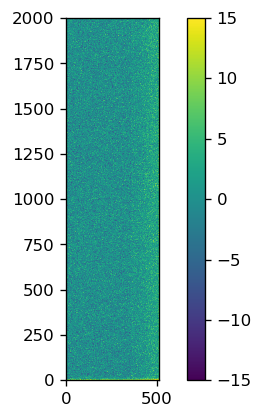

In [25]:
plt.imshow(superbias.getArray(), origin='lower', vmin=-15, vmax=15)
plt.colorbar()
plt.show()

In [80]:
detector = raw1.clone().getDetector()
data = detector[amp].getRawBBox()
imaging =  detector[amp].getRawDataBBox()
oscan = detector[amp].getRawHorizontalOverscanBBox()
im = raw1.clone()[data].getMaskedImage().getImage().clone()
unbiased = imutil.unbias_and_trim(im, oscan, imaging, bias_method='spline', bias_frame=superbias)

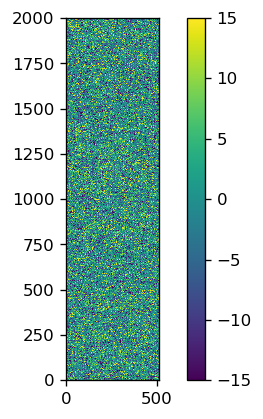

In [81]:
plt.imshow(unbiased.getArray(), origin='lower', vmin=-15, vmax=15)
plt.colorbar()
plt.show()

### Subtract the two overscan and bias corrected images

In [82]:
diff = unbiased.clone().getArray() - sub_im1.getImage().clone().getArray()

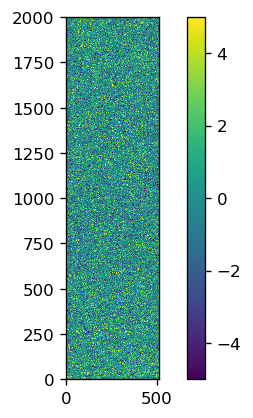

In [84]:
plt.imshow(diff, origin='lower', vmin=-5, vmax=5)
plt.colorbar()
plt.show()

## Write function to calculate gains given sensor and amplifier number

In [2]:
def calculate_gains(rtm_path, sensor, hduidx):
    
    '''
    @params
    
    rtm_path: str
    
    sensor: 0-8 mapping??
    
    hduidx: range?? mapping??
    '''

    ## Initialize the Butler to point to RTM data
    butler = Butler(rtm_path)

    ## Get individual exposures
    visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'}) ## what is 'testType' ??
    gain = {}
    exp_time = {}
    
    nn = int(len(visits) / 2)
    
    #Initialize an empty array for storing the output
    nn = int(len(visits) / 2)    
    results = np.empty(nn, dtype=[('visit1', 'int'), ('visit2', 'int'), ('index', 'int'), ('gain', 'f4'), ('exp_time', 'f4')])

    i = 0
    ## Assuming pairs are visits listed one after another
    for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
        # Get ISR data for first image
        dId = {'visit': visit1, 'detector': sensor}
        raw1 = butler.get('raw', **dId)
        bias1 = butler.get('bias', **dId)
        time1 = raw1.getInfo().getVisitInfo().getExposureTime()

        # Get ISR data for second image
        dId = {'visit': visit2, 'detector': sensor}
        raw2 = butler.get('raw', **dId)
        bias2 = butler.get('bias', **dId)
        time2 = raw2.getInfo().getVisitInfo().getExposureTime()
        if abs(time1 - time2) > 0.01:
            "Mismatched exptimes"
            continue

        # run ISR on both images
        result1 = isr.run(raw1, bias=bias1)
        result2 = isr.run(raw2, bias=bias2)

        detector = result1.exposure.getDetector()
        amp = detector[hduidx]

        sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
        #arr1 = sub_im1.getImage().getArray()
        sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
        #arr2 = sub_im2.getImage().getArray()

        # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
        diff_im = sub_im1.clone()
        diff_im -= sub_im2

        sum_im = sub_im1.clone()
        sum_im += sub_im2

        diff_im *= diff_im
        diff_im /= sum_im

        stats = afwMath.makeStatistics(diff_im, afwMath.MEDIAN | afwMath.MEAN)
        # Compute gain for this amp.
        gain[visit1] = 1/stats.getValue(afwMath.MEAN)
        exp_time[visit1] = time1
        results[i]['visit1'] = visit1
        results[i]['visit2'] = visit2
        results[i]['index'] = i
        results[i]['gain'] = gain[visit1]
        results[i]['exp_time'] = exp_time[visit1]
        #print("visit %i,%i -- %i of %i -- gain=%f, exposure time(s)=%f"%(visit1, visit2, i, len(visits)/2, gain[visit1], exp_time[visit1], ))
        print(i, visit1, visit2)
        i += 1
        
    return(results)

In [ ]:
sensor2_amp2_gains = calculate_gains( '/project/bootcamp/repo_RTM-007/', 2, 2)

In [ ]:
afw_display.mtv(sub_im1) # display an example image

In [ ]:
visit_keys = exp_time.keys()
x = [exp_time[visit] for visit in visit_keys]
y = [gain[visit] for visit in visit_keys]

In [ ]:
plt.scatter(x, y)
plt.ylim(0, 1)

## Test effects of different bias/offset corrections on gain calculations

In [51]:
#butler.getKeys('raw')
#help(raw1)
#print(raw1.getMetadata())
#help(detector['C00'])
## butler.getKeys('raw')
## help(butler)